## Case Study (Predict Bankruptcy)

In [139]:
# installing packages

import pandas as pd
import numpy as np
import sys
# for visualisation
import plotly.io as pio
pio.templates.default = "plotly_dark"
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import missingno as msn
import matplotlib.pyplot as plt

# type annotations
from typing import Tuple, Optional

# for modelling 
import lightgbm as lgb
from scipy.stats import pointbiserialr

from sklearn.metrics import PrecisionRecallDisplay, precision_score,recall_score,confusion_matrix
import shap

In [2]:
# setting display constraints
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = 100

In [3]:
def read_xlsx(path: str, sheet_name: str) -> pd.DataFrame:
    """
    This function read the XLSX files given a sheetname 
    """
    try:
        data = pd.read_excel(open(path,"rb"), sheet_name=sheet_name)
    except FileNotFoundError:
        print("file not found")
    return data


In [4]:
path = "../data/business_bankruptcy_prediction.xlsx"
data_sheet = "data"
target="Bankruptcy"

data = read_xlsx(path=path, sheet_name=data_sheet)
data.columns = data.columns.str.strip() 

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6819 entries, 0 to 6818
Data columns (total 97 columns):
 #   Column                                                   Non-Null Count  Dtype  
---  ------                                                   --------------  -----  
 0   ROA(C) before interest and depreciation before interest  6819 non-null   float64
 1   ROA(A) before interest and % after tax                   6819 non-null   float64
 2   ROA(B) before interest and depreciation after tax        6818 non-null   float64
 3   Operating Gross Margin                                   6819 non-null   float64
 4   Realized Sales Gross Margin                              6818 non-null   object 
 5   Operating Profit Rate                                    6819 non-null   float64
 6   Pre-tax net Interest Rate                                6819 non-null   float64
 7   After-tax net Interest Rate                              6819 non-null   float64
 8   Non-industry income and expe

In [6]:

def check_missing(data: pd.DataFrame, plot:bool=False)-> str:
     """
     The function checks if the data has missing features and displays them
     """
     
     if plot:
          msn.matrix(data, figsize=(45,8),sparkline=False)
     missing_total = data.isna().sum().sum()
     print(f"There are in total {missing_total} missing values in the data.")
     if missing_total !=0:
          print(f"Following are the list of columns with their corresponding missing number of values.\
          \n{data.isna().sum()[data.isna().sum()>0]}")


def plot_dist_bar(data1: pd.Series, data2: pd.Series, title:str, 
index1:Optional[list]=None, index2:Optional[list]=None,custom_index:bool=False) -> go.Figure:
    """
    Uses plotly to plot bar charts with a simplified interface
    """
    fig=make_subplots(1,2)
    
    if custom_index:
        fig.append_trace(go.Bar(x=index1, y=data1.values,
        name="values"), row=1, col=1)

        fig.append_trace(go.Bar(x=index2, 
                    y=np.round(data2.values,2)*100,
                    name="%"),
                    row=1, col=2)
   
    else:
        fig.append_trace(go.Bar(x=data1.index, y=data1.values,
        name="values"), row=1, col=1)

        fig.append_trace(go.Bar(x=data2.index, 
                    y=np.round(data2.values,2)*100,
                    name="%"),
                    row=1, col=2)

    fig.update_layout(title=title,width=1000, height=500,
    yaxis_title="frequency",yaxis2_title="%",
    xaxis_tickangle=-90,xaxis2_tickangle=-90)
    
    fig.show()

def get_dist(data:pd.DataFrame, col:str)-> Tuple[pd.DataFrame, pd.DataFrame]:
    perc = data[col].value_counts(normalize=True)
    num = data[col].value_counts()
    return (num, perc)

In [7]:
check_missing(data=data)

There are in total 8 missing values in the data.
Following are the list of columns with their corresponding missing number of values.          
ROA(B) before interest and depreciation after tax    1
Realized Sales Gross Margin                          1
Net Value Per Share (C)                              1
Per Share Net profit before tax (Yuan ¬•)            1
Regular Net Profit Growth Rate                       1
Net Value Growth Rate                                1
Inventory and accounts receivable/Net value          1
Inventory/Working Capital                            1
dtype: int64


In [8]:
data_nomsn = data.dropna(axis=0)
check_missing(data=data_nomsn)

There are in total 0 missing values in the data.


In the below data we observe that the is a class imbalance, this suggests that during modelling we need to manage the imbalance. 

In [9]:
target_dist_num, target_dist_perc = get_dist(data=data_nomsn,col=target)
target_index = ["Thrive","Bankruptcy"]
plot_dist_bar(target_dist_num,target_dist_perc,title="Data Distribution", custom_index=True, 
index1=target_index,index2=target_index)

In [10]:
company_dist_num, company_dist_perc = get_dist(data=data_nomsn,col="Company type")
plot_dist_bar(company_dist_num,company_dist_perc,title="Data Distribution")

In [11]:
grp1=["Company type","Bankruptcy"]

data_agg = (
    data_nomsn.groupby(grp1)
    .agg({"Bankruptcy":"count"})
    )
data_agg["Bankruptcy %"] = (data_agg
.groupby(level=0)
.apply(lambda x:round(x / float(x.sum()),2)))

data_agg = data_agg.rename(columns={"Bankruptcy": "values", "Bankruptcy %":"perc%"}).reset_index()
data_agg["index"] = data_agg["Company type"].astype(str)+"_"+data_agg["Bankruptcy"].astype(str)

data_agg.set_index("index", inplace = True)
data_agg = data_agg.drop(grp1, axis=1)

In [12]:
comp_type_index = list(data_agg.index.values)
plot_dist_bar(data_agg["values"],data_agg["perc%"], title="Bankruptcy")

In [13]:
data_variance  = data_nomsn.loc[:,data_nomsn.apply(pd.Series.nunique) != 1]
print(f"The feature/features {set(data_nomsn.columns).difference(set(data_variance.columns))} \
has/have no variance and are nearly constant and it has been dropped")

The feature/features {'Net Income Flag'} has/have no variance and are nearly constant and it has been dropped


In [14]:
# fixing datatype issue, numerical assigned as categorical
print(data_variance.select_dtypes(include="object").head())
potential_conversion_col = ["Realized Sales Gross Margin", "Allocation rate per person"]

  Realized Sales Gross Margin Allocation rate per person     Company type
0                    0.601457                   0.037135      Partnership
1                    0.610235                   0.012335      Partnership
2                    0.601364                   0.141016      Partnership
3                    0.583541                    0.02132      Partnership
4                    0.598783                   0.023988  Limited Company


In [15]:
for c in potential_conversion_col:
    data_variance.loc[:,c] = (data_variance.loc[:,c]
    .replace(to_replace='(\d*\.?\d*)',value=0, regex=True)
    .astype(float))

/var/folders/2z/yr5vgc5x38s4kz3c_crxr4q00000gn/T/ipykernel_4497/3722411541.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [16]:
# convert categoricals to float
cat_cols = list(data_variance.dtypes[data_variance.dtypes=="object"].index)
for c in cat_cols:
    data_variance.loc[:,c] = data_variance.loc[:,c].astype("category")


/var/folders/2z/yr5vgc5x38s4kz3c_crxr4q00000gn/T/ipykernel_4497/4070426772.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
data_num = data_variance.select_dtypes(exclude="category")
data_cat = data_variance.select_dtypes(include="category")

### Point Biseral Correlation

In [18]:
pointbiserial_dict = {}
for c in data_num.columns:
    pointbiserial_dict[c+"_"+target] = pointbiserialr(data_num[c].values, data_num[target].values)[0]
    

In [19]:
pb_corr = pd.Series(pointbiserial_dict).to_frame(name="correlation").sort_values(by="correlation")

fig = go.Figure([go.Bar(x=pb_corr.index, y=pb_corr.values.flatten())])
fig.update_layout(width=1200, height=800,xaxis_tickangle=-90, title="Point Biseral Correlation")


In [20]:
corr = data_num.drop(target, axis=1).corr()
corr_mask = np.triu(np.ones_like(corr, dtype=bool))
corr = corr.mask(corr_mask)

fig = go.Figure(data=go.Heatmap(x=corr.columns,y=corr.index,z=corr.values))
fig.update_layout(width=1200, height=1200,xaxis_tickangle=-90)
fig.show()

In [21]:
high_corr = (corr.unstack()
.reset_index()
.dropna()
.rename(columns={"level_0":"feat1","level_1":"feat2",0:"correlation"})
.assign(abs_correlation=lambda x: round(np.abs(x["correlation"]),2)))
high_corr = high_corr[high_corr["abs_correlation"]>=0.9]

In [22]:
high_corr_pvt=high_corr.pivot(index="feat1",columns="feat2",values="abs_correlation")
fig = go.Figure(data=go.Heatmap(x=high_corr_pvt.columns,y=high_corr_pvt.index,z=high_corr_pvt.values))
fig.update_layout(width=1000, height=1000,xaxis_tickangle=-90)
fig.show()

In [23]:
from sklearn.model_selection import train_test_split
X, y = (data_variance.drop(target,axis=1),data_variance[target])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, stratify=data_variance[target])

# train_dt = pd.concat([X_train,y_train],axis=1)
# test_dt = pd.concat([X_test,y_test],axis=1)

## LightGBM Baseline

In [24]:
train_dt = lgb.Dataset(data=X_train,label=y_train)
test_dt = lgb.Dataset(data = X_test, label=y_test, reference=train_dt)


In [46]:
params = {
        'objective': 'binary',
        'metric':'binary_logloss',
        'num_leaves': 10,
        'learning_rate':0.01,
        'is_unbalance':True,
}
evals={}

mod = lgb.train(params=params, 
                num_boost_round=60,
                train_set = train_dt, 
                valid_sets=[train_dt, test_dt],
                callbacks = [lgb.record_evaluation(evals)])

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 175, number of negative: 5273
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021944 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23716
[LightGBM] [Info] Number of data points in the train set: 5448, number of used features: 94
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032122 -> initscore=-3.405569
[LightGBM] [Info] Start training from score -3.405569


<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

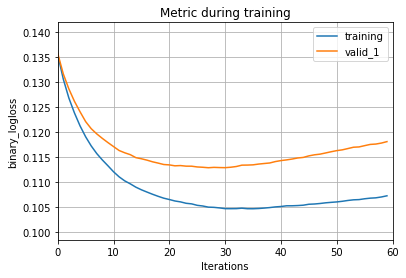

In [47]:
lgb.plot_metric(evals)

In [48]:
# fig, ax = plt.subplots(figsize=(10,15))
# lgb.plot_importance(mod, ax = ax)

In [49]:
pred_train = mod.predict(X_train)
pred_test = mod.predict(X_test)

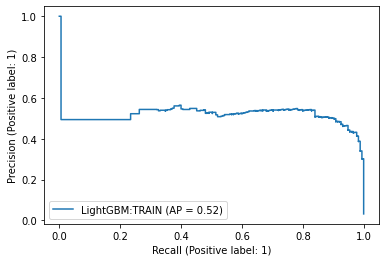

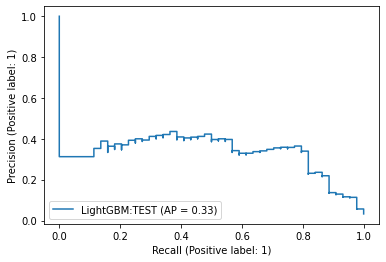

In [50]:
display1 = PrecisionRecallDisplay.from_predictions(y_train, pred_train, name="LightGBM:TRAIN")
display2 = PrecisionRecallDisplay.from_predictions(y_test, pred_test, name="LightGBM:TEST")

In [78]:
# prec, recall, threshold = precision_recall_curve(y_test, pred_test)
confusion_matrix(y_train,pred_train>0.5)

array([[5273,    0],
       [ 175,    0]])

In [52]:
explainer = shap.TreeExplainer(mod)
shap_values = explainer.shap_values(X_train)

/Users/convergeml/engineering/casestudy/bankruptcy_prediction/.venv/lib/python3.8/site-packages/shap/explainers/_tree.py:353: UserWarning:

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



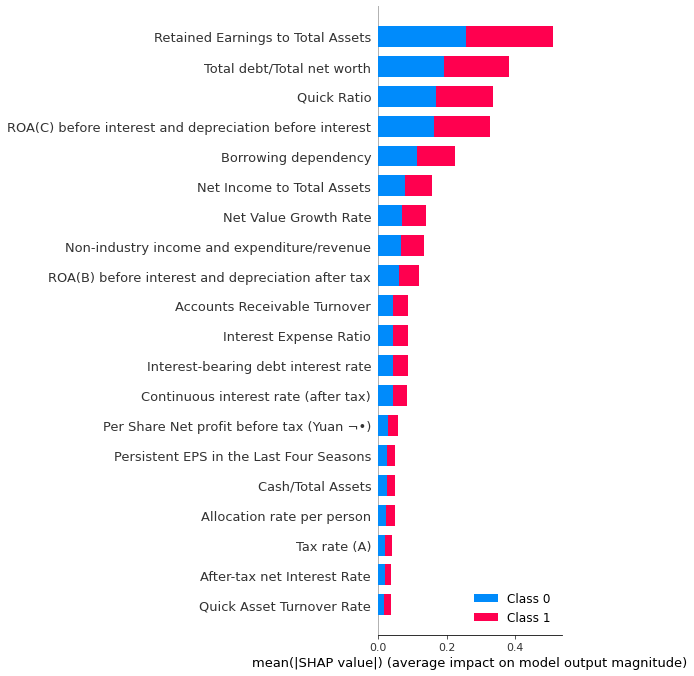

In [53]:
shap.summary_plot(shap_values, X_train)

In [54]:
# for name in X_train.columns:
#     shap.dependence_plot(name, shap_values[1], X_train,interaction_index="Borrowing dependency")

## Catboost Baseline

In [66]:
from catboost import CatBoostClassifier
mod2 = CatBoostClassifier(iterations=10,
                           learning_rate=0.01,
                           depth=4,
                           scale_pos_weight=5273/175)

In [67]:
mod2.fit(X_train,y_train,cat_features=['Company type'])

0:	learn: 0.6841995	total: 33.9ms	remaining: 305ms
1:	learn: 0.6766701	total: 51.4ms	remaining: 206ms
2:	learn: 0.6687380	total: 68ms	remaining: 159ms
3:	learn: 0.6613925	total: 107ms	remaining: 161ms
4:	learn: 0.6534481	total: 119ms	remaining: 119ms
5:	learn: 0.6456950	total: 148ms	remaining: 98.8ms
6:	learn: 0.6392380	total: 175ms	remaining: 75.2ms
7:	learn: 0.6311672	total: 187ms	remaining: 46.8ms
8:	learn: 0.6237489	total: 198ms	remaining: 22ms
9:	learn: 0.6140982	total: 219ms	remaining: 0us


In [69]:
# Get predicted probabilities for each class
pred_train_cat = mod2.predict_proba(X_train)
pred_test_cat = mod2.predict_proba(X_test)

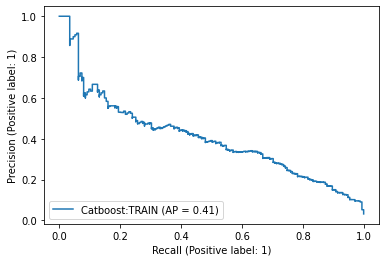

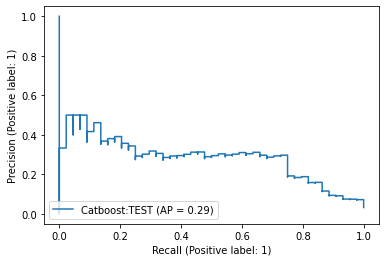

In [74]:
display3 = PrecisionRecallDisplay.from_predictions(y_train, pred_train_cat[:,1], name="Catboost:TRAIN")
display4 = PrecisionRecallDisplay.from_predictions(y_test, pred_test_cat[:,1], name="Catboost:TEST")

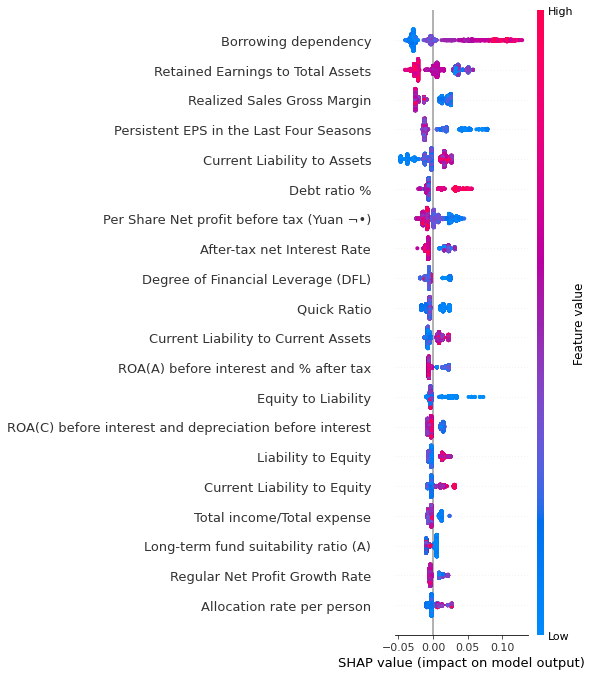

In [76]:
explainer2 = shap.TreeExplainer(mod2)
shap_values2 = explainer2.shap_values(X_train)
shap.summary_plot(shap_values2, X_train)

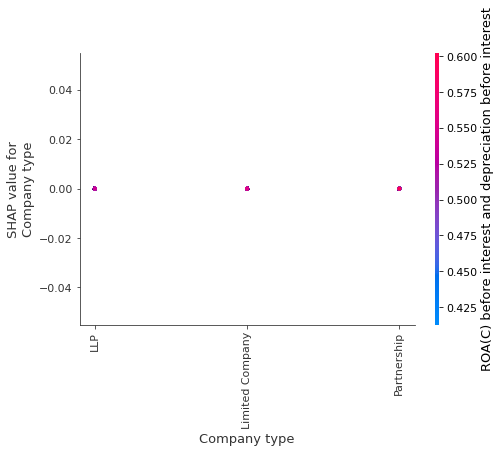

In [136]:
shap.dependence_plot("Company type", shap_values[1], X_train)

In [80]:
confusion_matrix(y_train,pred_train_cat[:,1]>0.5)

array([[4420,  853],
       [  18,  157]])

In [140]:
print(precision_score(y_pred=pred_train_cat[:,1]>0.5,y_true=y_train))
print(recall_score(y_pred=pred_train_cat[:,1]>0.5,y_true=y_train))

0.15544554455445544
0.8971428571428571


In [141]:
157/(157+18)

0.8971428571428571